# Vehicle Detection Project

#### The goals / steps of this project are the following:

- Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
- Apply a color transform and append binned color features, as well as histograms of color, to the HOG feature vector. 
- Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
- Implement a sliding-window technique and use the trained classifier to search for vehicles in images.
- Run the pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
- Estimate a bounding box for vehicles detected.


### Feature extraction

Text(0.5,1,'non_vehicle example')

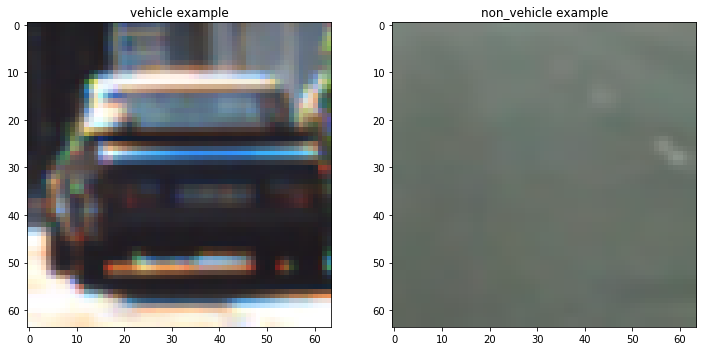

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline


# First check the data
v_image = mpimg.imread('./vehicles/KITTI_extracted/1.png')
nv_image = mpimg.imread('./non-vehicles/GTI/image1.png')

f,ax = plt.subplots(1,2,figsize = (12,9))
ax[0].imshow(v_image)
ax[0].set_title('vehicle example')
ax[1].imshow(nv_image)
ax[1].set_title('non_vehicle example')

#### input all the training data

Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32


Text(0.5,1,'Example Not-car Image')

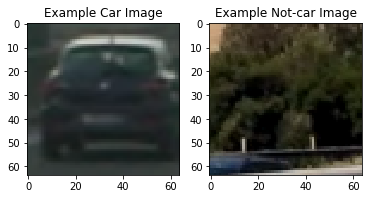

In [2]:
import numpy as np
import glob # The glob module finds all the pathnames matching a specified pattern according to the rules
images = glob.glob('./*/*/*.png')
cars = []
notcars = []

for image in images:
    if 'non-vehicles' in image:
        notcars.append(image)
    else:
        cars.append(image)
        
def data_look(car_list,noncar_list):
    data_dict = {}
    data_dict['n_cars'] = len(car_list)
    data_dict['n_notcars'] = len(noncar_list)
    return data_dict


data_info = data_look(cars,notcars)
print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')

# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

print('of size: ',car_image.shape, ' and data type:', 
      car_image.dtype)


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')


#print(np.max(car_image[:,:,1])) #color range in 0~1

#### HOG feature extraction

In [3]:
from skimage.feature import hog
import cv2

def get_hog_features(image,orient,pix_per_cell,cell_per_block,vis=False,feature_vec=True):
    if vis == True:
        features, hog_images = hog(image,orientations=orient,
                                     pixels_per_cell=(pix_per_cell,pix_per_cell),
                                     cells_per_block=(cell_per_block,cell_per_block),
                                     visualise=True,feature_vector=False,
                                     block_norm="L2-Hys")
        return features,hog_images

    else:
        features = hog(image,orientations=orient,
                                     pixels_per_cell=(pix_per_cell,pix_per_cell),
                                     cells_per_block=(cell_per_block,cell_per_block),
                                     visualise=False,feature_vector=False,
                                     block_norm="L2-Hys")
        return features
       

        
        

#### set related hyperparameters

In [4]:
color_space='YCrCb'
spatial_size=(32,32)
hist_bins=32
hist_range=(0,256)
orient=9
pix_per_cell=8
cell_per_block=2

Text(0.5,1,'Example HOG Image')

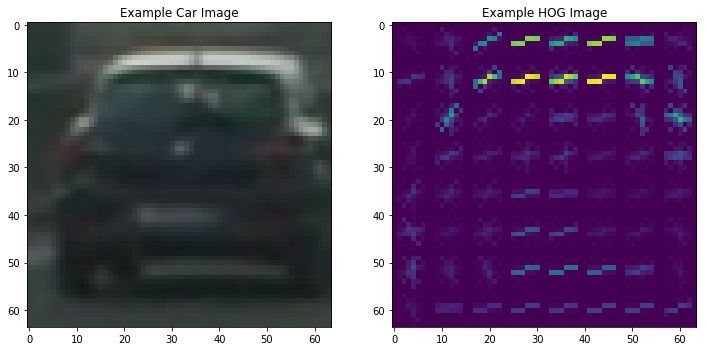

In [5]:
gray = cv2.cvtColor(car_image, cv2.COLOR_RGB2GRAY)
features,hog_images = get_hog_features(gray,orient,pix_per_cell,cell_per_block,vis=True,feature_vec=True)

# Plot the examples
fig = plt.figure(figsize=(12,9))
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_images)
plt.title('Example HOG Image')




#### Color transform

In [9]:
from sklearn.preprocessing import StandardScaler

def bin_spatial(img,size): #to resize the image, blur image making it smaller
    features = cv2.resize(img,size).ravel()
    return features

def color_hist(img,nbins,bins_range):
    channel1_hist = np.histogram(img[:,:,0]*255,bins=nbins,range=bins_range)
    channel2_hist = np.histogram(img[:,:,1]*255,bins=nbins,range=bins_range)
    channel3_hist = np.histogram(img[:,:,2]*255,bins=nbins,range=bins_range)
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0])).ravel()
    return hist_features
            

#### Features preprocessing (combine and normalize)

In [10]:
# Normalize and Combine hog/spatial/color features
def extract_features(images,color_space,spatial_size,hist_bins,hist_range,
                     orient,pix_per_cell,cell_per_block,vis=False,feature_vec=True):
    features = []
    for img in images:
        image = mpimg.imread(img)
        feature = []
        if color_space !='RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: 
            feature_image = np.copy(image)    
        
        spatial_features = bin_spatial(feature_image,spatial_size)
        hist_features = color_hist(feature_image,hist_bins,hist_range)
        hog_features = []
        for i in range(feature_image.shape[-1]):
            hog_feature = get_hog_features(feature_image[:,:,i],orient,pix_per_cell,cell_per_block,vis=False,feature_vec=True)
            hog_features.append(hog_feature)
        hog_features = np.array(hog_features).ravel()
        # Taken spatial, color and hog features into account
        feature = np.concatenate((spatial_features,hist_features,hog_features))
        features.append(feature)
        
    return features

#### extract features

In [11]:
import time
t1 = time.time()
car_features = extract_features(cars,color_space,spatial_size,hist_bins,hist_range,orient,pix_per_cell,cell_per_block)
notcar_features = extract_features(notcars,color_space,spatial_size,hist_bins,hist_range,orient,pix_per_cell,cell_per_block)
t2 = time.time()

In [12]:
print('feature vector length',np.array(car_features).shape)
print(round(t2 - t1, 2), 'seconds to extract the features.')

feature vector length (8792, 8460)
116.61 seconds to extract the features.


In [13]:
from sklearn.preprocessing import StandardScaler

x = np.vstack((car_features,notcar_features)).astype(np.float64)
X_scaler = StandardScaler().fit(x)
scaled_X = X_scaler.transform(x)


X = scaled_X
Y = np.hstack((np.ones(len(car_features)),np.zeros(len(notcar_features))))

#### Train a linear SVM classifier

In [14]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split


X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state = np.random.randint(0,100))
svc = LinearSVC()
t1 = time.time()
svc.fit(X_train,Y_train)
t2= time.time()
print('total examples',len(Y_train))
print(round(t2 - t1,2), 'secondes to train model')


total examples 14208
22.79 secondes to train model


In [15]:
accuracy = svc.score(X_test,Y_test)
print('Test accuracy is ',round(accuracy,4))
print('total test size is',len(Y_test))

Test accuracy is  0.9885
total test size is 3552


### Sliding-window technique

In [16]:
def draw_box(img,bboxs,color=(0,0,255),thick=6):
    imcopy = np.copy(img)
    color = np.array(color)/255
    for bbox in bboxs:
        cv2.rectangle(imcopy,bbox[0],bbox[1],color,thick)
    return imcopy

In [17]:
def slide_window(img,x_start_stop=[None,None],y_start_stop=[None,None],xy_window=(64,64),xy_overlap=(0.5,0.5)):
    if x_start_stop[0]==None:
        x_start_stop[0]=0
    if x_start_stop[1]==None:
        x_start_stop[1]=img.shape[1]
    if y_start_stop[0]==None:
        y_start_stop[0]=0
    if y_start_stop[1]==None:
        y_start_stop[1]=img.shape[0]
        
    
    xspan = x_start_stop[1]-x_start_stop[0]
    yspan = y_start_stop[1]-y_start_stop[0]
    
    nx_pix_per_step = np.int(xy_window[0]*(1-xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1-xy_overlap[1]))
    
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    
    nx_window = np.int((xspan-nx_buffer)/nx_pix_per_step)
    ny_window = np.int((yspan-ny_buffer)/ny_pix_per_step)
    
    window_list = []
    for ys in range(ny_window):
        for xs in range(nx_window):
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            window_list.append(((startx,starty),(endx,endy)))
    return window_list

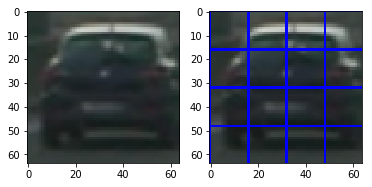

In [18]:
windows = slide_window(car_image,x_start_stop=[None,None],y_start_stop=[None,None],xy_window=(32,32),xy_overlap=(0.5,0.5))
window_image = draw_box(car_image,windows,color=(0,0,255),thick=1)
plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.subplot(122)
plt.imshow(window_image)

### test with video stream

#### Extract feature from a sigle image

In [19]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space, spatial_size,
                        hist_bins, hist_range, orient, pix_per_cell, cell_per_block,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image,spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image,hist_bins,hist_range)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        hog_features = get_hog_features(feature_image, orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)



#### Search through windows to get hotmap

In [20]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space, 
                    spatial_size, hist_bins, 
                    hist_range, orient, 
                    pix_per_cell, cell_per_block, 
                    spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
    

#### Train the model with all the sample examples

In [21]:
from sklearn.externals import joblib
import pickle
filename = "svm_model/svm.pkl"
joblib.dump(svc, filename)
pickle.dump(X,open("svm_model/scaled_X_data.pkl","wb"))
pickle.dump(Y,open("svm_model/y_data.pkl","wb"))

print("The trained model is saved.")


The trained model is saved.


In [22]:
params = {
    'svc':svc,
    'scaler':X_scaler,
    'orient':orient,
    'pix_per_cell':pix_per_cell,
    'cell_per_block':cell_per_block,
    'spatial_size':spatial_size,
    'hist_bins':hist_bins,
    'hist_range':hist_range,
    'color_space':color_space,
}
pickle.dump(params,open("svm_model/svc_pickle.p","wb"))

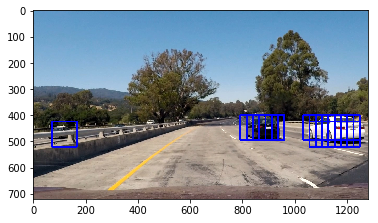

In [29]:

dist_pickle = pickle.load( open("svm_model/svc_pickle.p", "rb" ) )
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]

img = mpimg.imread('test_images/test1.jpg')

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = cv2.cvtColor(img_tosearch,cv2.COLOR_RGB2YCrCb)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    on_windows = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, spatial_size)
            hist_features = color_hist(subimg, hist_bins, hist_range)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                on_windows.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    return draw_img,on_windows
    
ystart = 400
ystop = 656
scale = 1.5
    
out_img,on_windows = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

plt.imshow(out_img)

#### Hotmap

In [34]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap


def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        #cv2.rectangle(img, bbox[0], bbox[1], color=(0,0,255), 6)
        img = draw_box(img, [bbox], color=(0, 0, 255), thick=6)
    # Return the image
    return img


Text(0.5,1,'Heat Map')

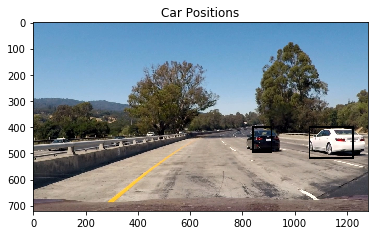

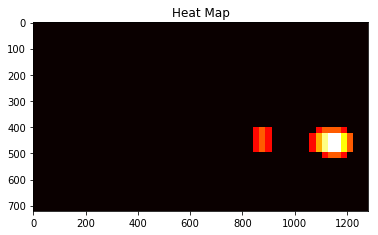

In [42]:
from scipy.ndimage.measurements import label
heat = np.zeros_like(img[:,:,0]).astype(np.float)
box_list = on_windows

# Add heat to each box in box list
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,2)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(img), labels)

plt.figure()
plt.imshow(draw_img)
plt.title('Car Positions')
plt.figure()
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')

### Vehicle pipeline

In [36]:
def detect_vehicles(image):
    out_img, all_windows = find_cars(image, ystart, 
                                     ystop, scale, svc, X_scaler, orient, 
                                     pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    box_list = all_windows

    # Add heat to each box in box list
    heat = add_heat(heat,box_list)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    return draw_img

In [37]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [45]:
test_video_output = "./output_videos/test_video_output.mp4"
clip1 = VideoFileClip("./test_video.mp4")
white_clip1 = clip1.fl_image(detect_vehicles)
%time white_clip1.write_videofile(test_video_output, audio=False)

[MoviePy] >>>> Building video ./output_videos/test_video_output.mp4
[MoviePy] Writing video ./output_videos/test_video_output.mp4


 97%|█████████▋| 38/39 [00:18<00:00,  2.27it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_videos/test_video_output.mp4 

CPU times: user 17.3 s, sys: 676 ms, total: 17.9 s
Wall time: 19.5 s


In [46]:
project_video_output = "./output_videos/project_video_output.mp4"
clip2 = VideoFileClip("./project_video.mp4")
white_clip2 = clip2.fl_image(detect_vehicles)
%time white_clip2.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video ./output_videos/project_video_output.mp4
[MoviePy] Writing video ./output_videos/project_video_output.mp4


100%|█████████▉| 1260/1261 [10:22<00:00,  2.16it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_videos/project_video_output.mp4 

CPU times: user 9min 35s, sys: 21.4 s, total: 9min 56s
Wall time: 10min 24s


#### Further improvement should be worked on smooth the detected video that filter out the false predictio based on the previous frame